# Copyright

<PRE>
Jelen Jupyter notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2021 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Kalapos András
</PRE>

# Regresszió mély tanulással

Ebben a notebookban a gépi tanulás egyik "Hello world"-jét fogjuk megismeri. Ehhez a Boston Housing Prices adatbázist fogjuk felhasználni. 

Az adatbázis formátumának leírását itt találjuk: https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names
Magát az adatbázist pedig innen tölthetjük le: https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data

Töltsük le az utóbbi CSV fájlt és mentsük a jelenlegi Python forrás / notebook mellé.

Következő lépésként importáljuk a szükséges modulokat és állítsunk be egy random seed-et:

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import copy
import pandas as pd
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler


np.random.seed(123)

Ezután töltsük le és töltsük be az adatokat, válasszuk szét a train-validation-test adathalmazokat és standardizáljuk a bemeneteket:

In [2]:
import urllib.request
urllib.request.urlretrieve ("https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data", "housing.data")
urllib.request.urlretrieve ("https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names", "housing.names")

('housing.names', <http.client.HTTPMessage at 0x7f3ad03b9a90>)

In [ ]:
!cat housing.names

1. Title: Boston Housing Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the 
                 demand for clean air', J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

3. Past Usage:
   -   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 
       1980.   N.B. Various transformations are used in the table on
       pages 244-261.
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   Concerns housing values in suburbs of Boston.

5. Number of Instances: 506

6. Number of Attributes: 13 continuous attributes (including "class"
                

In [3]:
# Adatok betöltése
df = pd.read_csv("housing.data", delim_whitespace=True, header=None)

# Megjelenítéshez fejléc hozzáadása
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
# Első 5 sor megjelenítése
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
dataset = df.values
test_split = 0.1
valid_split = 0.1

X = dataset[:,0:13]
Y = dataset[:,13]

v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

X_test = X[t_index:]
Y_test = Y[t_index:]
X_valid = X[v_index:t_index]
Y_valid = Y[v_index:t_index]
X = X[:v_index]
Y = Y[:v_index]

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


Ezt követően adjuk meg a callback függvényeket:

In [5]:
early_stopping=EarlyStopping(patience=40, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

És hozzuk létre a hálót és tanítsuk be:

In [7]:
# Modell definiálás
model = Sequential()
model.add(Dense(units=60, input_dim=X.shape[1], activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='linear'))

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd)
history=model.fit(X,Y,epochs=10000, 
                  batch_size=16,
                  verbose=2,
                  validation_data=(X_valid, Y_valid),
                  callbacks=[checkpointer, early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10000
26/26 - 1s - loss: 172.5424 - val_loss: 26.3245

Epoch 00001: val_loss improved from inf to 26.32452, saving model to weights.hdf5
Epoch 2/10000
26/26 - 0s - loss: 38.9858 - val_loss: 39.9046

Epoch 00002: val_loss did not improve from 26.32452
Epoch 3/10000
26/26 - 0s - loss: 37.2487 - val_loss: 30.3189

Epoch 00003: val_loss did not improve from 26.32452
Epoch 4/10000
26/26 - 0s - loss: 33.7942 - val_loss: 27.2499

Epoch 00004: val_loss did not improve from 26.32452
Epoch 5/10000
26/26 - 0s - loss: 34.8039 - val_loss: 29.7395

Epoch 00005: val_loss did not improve from 26.32452
Epoch 6/10000
26/26 - 0s - loss: 30.3781 - val_loss: 32.5258

Epoch 00006: val_loss did not improve from 26.32452
Epoch 7/10000
26/26 - 0s - loss: 29.7215 - val_loss: 33.0142

Epoch 00007: val_loss did not improve from 26.32452
Epoch 8/10000
26/26 - 0s - loss: 29.5302 - val_loss: 25.6201

Epoch 00008: val_loss improved from 26.32452 to 25.62013, saving model to weights.hdf5
Epoch 9/10000
26/26 - 

A tanítás végeztével visszatöltjük a legjobb modellt, és kiértékeljük ennek teljesítményét a teszt adatokon. Mit jelenthet ez az érték?

In [15]:
from sklearn.metrics import mean_squared_error
model = load_model('weights.hdf5')
preds = model.predict(X_test)
test_err = mean_squared_error(Y_test,preds)
print("\nTeszt hiba: %f" % (test_err))


Teszt hiba: 12.013035


Tehát ez az jelenti, hogy sqrt(12.17)=3.488-at hibáz átlagosan a modell a teszt adatokon. És annyit jelent, hogy átlagosan 3488$-t téved a modellünk.

Az eredményeket vizsgáljuk meg grafikusan is:

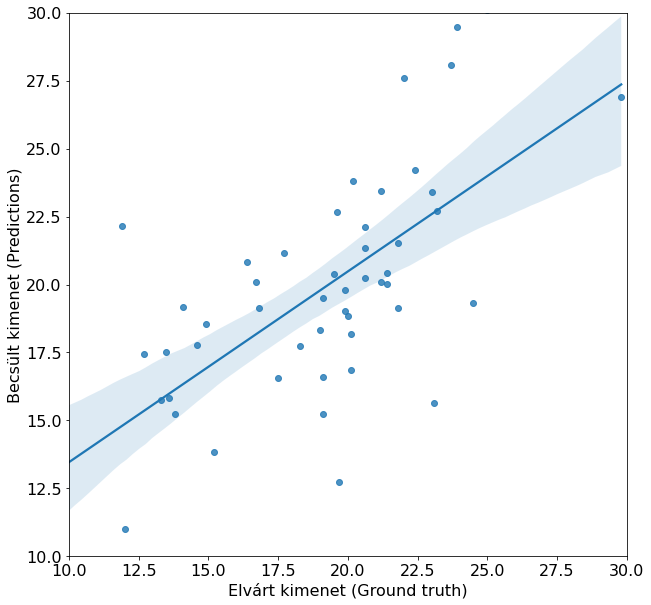

In [14]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size':16})
sns.regplot(x=Y_test, y=preds.reshape(-1)).set(xlim=(10,30),ylim=(10,30));
plt.xlabel("Elvárt kimenet (Ground truth)")
plt.ylabel("Becsült kimenet (Predictions)");

Mit jelent ez az ábra? Mit jelentene egy vízszintes egyenes? És egy függőleges egyenes?